# Generalities for GANs

* Import libraries
* Run on GPU if possible
* Create data loaders

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



# Neural Network class

* Generator
* Discriminator


In [2]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):

        h = F.relu(self.fc1(z)) # ReLU hidden layer of 400 nodes
        probabilities = torch.sigmoid(self.fc2(h)) # sigmoid output layer of 784 nodes
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):

        h = F.relu(self.fc1(x.view(-1, 784))) # ReLU hidden layer of 400 nodes
        probabilities = torch.sigmoid(self.fc2(h)) # sigmoid output layer of 1 node
        return probabilities

# Loss Function

In [3]:
# GAN Loss Function
#
# Inputs:
#    predictions: array of probabilities indicating whether the images are real or fake 
#    targets: array of 1s (real image) and 0s (fake image)
#
# Output:
#    BCE: binary cross entropy (scalar)
#
def gan_loss_function(predictions, targets):

    BCE = F.binary_cross_entropy(predictions, targets, reduction='sum')
    return BCE

# Training

In [4]:
# GAN Training
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    generator_optimizer: generator optimizer
#    discriminator: discriminator network
#    discriminator_optimizer: discriminator optimizer
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):

    # define real and fake labels
    real_label = 1
    fake_label = 0

    train_discriminator_loss = 0
    train_generator_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        batch_size = data.size(0)
        
        ###########################################################################
        ## part 1: train the discriminator (maximize log(D(x)) + log(1 - D(G(z))))
        discriminator_optimizer.zero_grad()
        
        # train with real data
        predictions = discriminator(data) # compute predictions
        labels = torch.full_like(predictions, real_label) # define labels
        discriminator_real_loss = gan_loss_function(predictions, labels) # calculate loss
        discriminator_real_loss.backward()
        
        # train with fake data
        noise = torch.randn(batch_size, 20).to(device) # sample embeddings
        fake_data = generator(noise) # generate fake data from sampled embeddings
        predictions = discriminator(fake_data.detach()) # compute predictions
        labels.fill_(fake_label) # define labels
        discriminator_fake_loss = gan_loss_function(predictions, labels) # calculate loss
        discriminator_fake_loss.backward()
        discriminator_loss = discriminator_real_loss.item() + discriminator_fake_loss.item() # sum loss from real and fake data
        train_discriminator_loss += discriminator_loss # add loss resulting from both real and fake data

        discriminator_optimizer.step()

        ###########################################################################
        ## part 2: train the generator (maximize log(D(G(z))) <=> minimize -log(D(G(z))))
        generator_optimizer.zero_grad()
        
        predictions = discriminator(fake_data) # re-compute predictions for fake data using updated discriminator
        labels.fill_(real_label)  # fake labels are real for generator cost
        generator_loss = gan_loss_function(predictions, labels)
        generator_loss.backward()
        train_generator_loss += generator_loss.item()

        generator_optimizer.step()

        ###########################################################################        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tGenerator Loss: {:.6f}\tDiscriminator Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                generator_loss.item() / len(data),
                discriminator_loss / (len(data) * 2))) # twice the amount of data (both real and fake)

    # calculate average generator loss, average discriminator loss
    average_generator_loss = train_generator_loss / len(train_loader.dataset)
    average_discriminator_loss = train_discriminator_loss / (len(train_loader.dataset) * 2) # twice the amount of data (with real and fake)
    print('====> Epoch: {} Average generator loss: {:.4f}\tAverage discriminator loss: {:.4f}'.format(
          epoch, average_generator_loss, average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss



# Testing


In [5]:
# GAN Test
#
# Have a look at the following tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#
# Inputs:
#    epoch: epoch #
#    generator: generator network
#    discriminator: discriminator network
#
# Outputs:
#    average_generator_loss: binary cross entropy (scalar)
#    average_discriminator_loss: binary cross entropy (scalar)
#
def gan_test(epoch, generator, discriminator):

    discriminator.eval()
    generator.eval()
    real_label = 1
    fake_label = 0
    test_discriminator_loss = 0
    test_generator_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            batch_size = data.size(0)

            ###########################################################################
            ## part 1: test the discriminator
            # test with real data
            predictions = discriminator(data) # compute predictions
            labels = torch.full_like(predictions, real_label) # define labels
            discriminator_real_loss = gan_loss_function(predictions, labels) # calculate loss

            # test with fake data
            noise = torch.randn(batch_size, 20).to(device) # sample embeddings
            fake_data = generator(noise) # generate fake data from sampled embeddings
            predictions = discriminator(fake_data) # compute predictions
            labels.fill_(fake_label) # define labels
            discriminator_fake_loss = gan_loss_function(predictions, labels) # calculate loss
            discriminator_loss = discriminator_real_loss.item() + discriminator_fake_loss.item() # sum loss from real and fake data
            test_discriminator_loss += discriminator_loss # add loss resulting from both real and fake data

            ###########################################################################
            ## part 2: test the generator
            labels.fill_(real_label)  # fake labels are real for generator cost
            generator_loss = gan_loss_function(predictions, labels) # reuse predictions of fake data from before
            test_generator_loss += generator_loss.item()

    average_generator_loss = test_generator_loss / len(test_loader.dataset)
    average_discriminator_loss = test_discriminator_loss / (len(test_loader.dataset) * 2) # twice the amount of data (both real and fake)
    print('====> Test set generator loss: {:.4f}\tTest set discriminator loss: {:.4f}'.format(average_generator_loss, average_discriminator_loss))
    return average_generator_loss, average_discriminator_loss

# Main

Train Epoch: 1 [0/60000 (0%)]	Generator Loss: 1.747705	Discriminator Loss: 0.683747
Train Epoch: 1 [12800/60000 (21%)]	Generator Loss: 4.096669	Discriminator Loss: 0.050099
Train Epoch: 1 [25600/60000 (43%)]	Generator Loss: 6.025687	Discriminator Loss: 0.011367
Train Epoch: 1 [38400/60000 (64%)]	Generator Loss: 5.883955	Discriminator Loss: 0.013471
Train Epoch: 1 [51200/60000 (85%)]	Generator Loss: 6.777428	Discriminator Loss: 0.002541
====> Epoch: 1 Average generator loss: 5.5170	Average discriminator loss: 0.0629
====> Test set generator loss: 5.5170	Test set discriminator loss: 0.0080
Sample of generated images


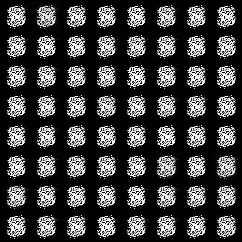



Train Epoch: 2 [0/60000 (0%)]	Generator Loss: 6.691116	Discriminator Loss: 0.003733
Train Epoch: 2 [12800/60000 (21%)]	Generator Loss: 8.805593	Discriminator Loss: 0.001124
Train Epoch: 2 [25600/60000 (43%)]	Generator Loss: 7.879464	Discriminator Loss: 0.000576
Train Epoch: 2 [38400/60000 (64%)]	Generator Loss: 5.026090	Discriminator Loss: 0.020153
Train Epoch: 2 [51200/60000 (85%)]	Generator Loss: 8.706079	Discriminator Loss: 0.008875
====> Epoch: 2 Average generator loss: 7.2757	Average discriminator loss: 0.0139
====> Test set generator loss: 8.3904	Test set discriminator loss: 0.0102
Sample of generated images


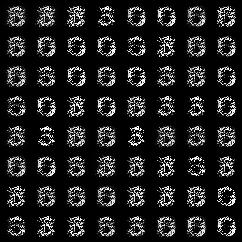



Train Epoch: 3 [0/60000 (0%)]	Generator Loss: 8.983500	Discriminator Loss: 0.004814
Train Epoch: 3 [12800/60000 (21%)]	Generator Loss: 7.039117	Discriminator Loss: 0.018852
Train Epoch: 3 [25600/60000 (43%)]	Generator Loss: 6.036730	Discriminator Loss: 0.016472
Train Epoch: 3 [38400/60000 (64%)]	Generator Loss: 7.881368	Discriminator Loss: 0.030397
Train Epoch: 3 [51200/60000 (85%)]	Generator Loss: 9.949671	Discriminator Loss: 0.009492
====> Epoch: 3 Average generator loss: 7.8606	Average discriminator loss: 0.0140
====> Test set generator loss: 7.8755	Test set discriminator loss: 0.0202
Sample of generated images


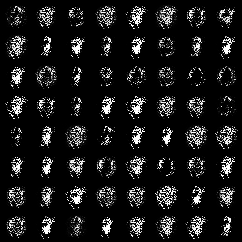



Train Epoch: 4 [0/60000 (0%)]	Generator Loss: 8.795973	Discriminator Loss: 0.009228
Train Epoch: 4 [12800/60000 (21%)]	Generator Loss: 7.210102	Discriminator Loss: 0.009363
Train Epoch: 4 [25600/60000 (43%)]	Generator Loss: 6.611593	Discriminator Loss: 0.009446
Train Epoch: 4 [38400/60000 (64%)]	Generator Loss: 7.161979	Discriminator Loss: 0.006427
Train Epoch: 4 [51200/60000 (85%)]	Generator Loss: 5.565666	Discriminator Loss: 0.022234
====> Epoch: 4 Average generator loss: 6.7746	Average discriminator loss: 0.0156
====> Test set generator loss: 4.9024	Test set discriminator loss: 0.0216
Sample of generated images


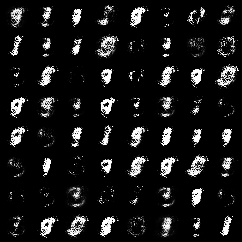



Train Epoch: 5 [0/60000 (0%)]	Generator Loss: 5.640444	Discriminator Loss: 0.027262
Train Epoch: 5 [12800/60000 (21%)]	Generator Loss: 7.886244	Discriminator Loss: 0.020038
Train Epoch: 5 [25600/60000 (43%)]	Generator Loss: 6.538294	Discriminator Loss: 0.009096
Train Epoch: 5 [38400/60000 (64%)]	Generator Loss: 6.250850	Discriminator Loss: 0.028643
Train Epoch: 5 [51200/60000 (85%)]	Generator Loss: 7.841625	Discriminator Loss: 0.029510
====> Epoch: 5 Average generator loss: 6.7883	Average discriminator loss: 0.0224
====> Test set generator loss: 6.0938	Test set discriminator loss: 0.0165
Sample of generated images


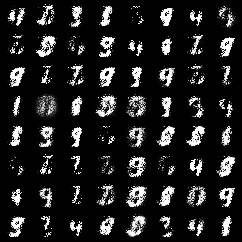



Train Epoch: 6 [0/60000 (0%)]	Generator Loss: 7.011961	Discriminator Loss: 0.006402
Train Epoch: 6 [12800/60000 (21%)]	Generator Loss: 7.154117	Discriminator Loss: 0.009174
Train Epoch: 6 [25600/60000 (43%)]	Generator Loss: 6.466286	Discriminator Loss: 0.061527
Train Epoch: 6 [38400/60000 (64%)]	Generator Loss: 6.444241	Discriminator Loss: 0.014736
Train Epoch: 6 [51200/60000 (85%)]	Generator Loss: 7.341766	Discriminator Loss: 0.010238
====> Epoch: 6 Average generator loss: 7.0318	Average discriminator loss: 0.0219
====> Test set generator loss: 6.4229	Test set discriminator loss: 0.0351
Sample of generated images


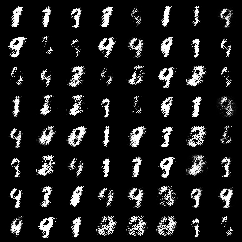



Train Epoch: 7 [0/60000 (0%)]	Generator Loss: 6.496037	Discriminator Loss: 0.036747
Train Epoch: 7 [12800/60000 (21%)]	Generator Loss: 6.825554	Discriminator Loss: 0.031256
Train Epoch: 7 [25600/60000 (43%)]	Generator Loss: 5.814433	Discriminator Loss: 0.025651
Train Epoch: 7 [38400/60000 (64%)]	Generator Loss: 7.604828	Discriminator Loss: 0.030227
Train Epoch: 7 [51200/60000 (85%)]	Generator Loss: 7.590096	Discriminator Loss: 0.012497
====> Epoch: 7 Average generator loss: 7.0181	Average discriminator loss: 0.0247
====> Test set generator loss: 6.7875	Test set discriminator loss: 0.0367
Sample of generated images


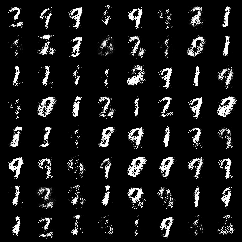



Train Epoch: 8 [0/60000 (0%)]	Generator Loss: 7.313449	Discriminator Loss: 0.025498
Train Epoch: 8 [12800/60000 (21%)]	Generator Loss: 6.839789	Discriminator Loss: 0.028594
Train Epoch: 8 [25600/60000 (43%)]	Generator Loss: 7.457376	Discriminator Loss: 0.025118
Train Epoch: 8 [38400/60000 (64%)]	Generator Loss: 6.932477	Discriminator Loss: 0.015453
Train Epoch: 8 [51200/60000 (85%)]	Generator Loss: 6.730859	Discriminator Loss: 0.054592
====> Epoch: 8 Average generator loss: 7.2179	Average discriminator loss: 0.0308
====> Test set generator loss: 6.7303	Test set discriminator loss: 0.0281
Sample of generated images


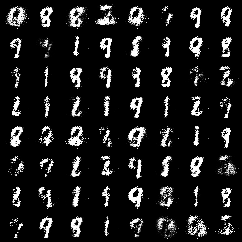



Train Epoch: 9 [0/60000 (0%)]	Generator Loss: 6.606241	Discriminator Loss: 0.016760
Train Epoch: 9 [12800/60000 (21%)]	Generator Loss: 6.397711	Discriminator Loss: 0.039741
Train Epoch: 9 [25600/60000 (43%)]	Generator Loss: 5.916987	Discriminator Loss: 0.049691
Train Epoch: 9 [38400/60000 (64%)]	Generator Loss: 6.309064	Discriminator Loss: 0.029626
Train Epoch: 9 [51200/60000 (85%)]	Generator Loss: 6.079309	Discriminator Loss: 0.036328
====> Epoch: 9 Average generator loss: 6.4843	Average discriminator loss: 0.0399
====> Test set generator loss: 5.5001	Test set discriminator loss: 0.0458
Sample of generated images


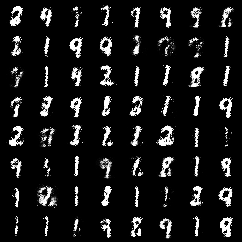



Train Epoch: 10 [0/60000 (0%)]	Generator Loss: 6.536350	Discriminator Loss: 0.029057
Train Epoch: 10 [12800/60000 (21%)]	Generator Loss: 5.487540	Discriminator Loss: 0.048751
Train Epoch: 10 [25600/60000 (43%)]	Generator Loss: 5.130280	Discriminator Loss: 0.053051
Train Epoch: 10 [38400/60000 (64%)]	Generator Loss: 4.938038	Discriminator Loss: 0.076760
Train Epoch: 10 [51200/60000 (85%)]	Generator Loss: 5.255962	Discriminator Loss: 0.059186
====> Epoch: 10 Average generator loss: 5.6406	Average discriminator loss: 0.0617
====> Test set generator loss: 5.1011	Test set discriminator loss: 0.0556
Sample of generated images


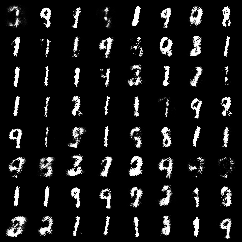



Train Epoch: 11 [0/60000 (0%)]	Generator Loss: 5.392022	Discriminator Loss: 0.070978
Train Epoch: 11 [12800/60000 (21%)]	Generator Loss: 5.352839	Discriminator Loss: 0.136766
Train Epoch: 11 [25600/60000 (43%)]	Generator Loss: 5.226415	Discriminator Loss: 0.059800
Train Epoch: 11 [38400/60000 (64%)]	Generator Loss: 5.754097	Discriminator Loss: 0.035779
Train Epoch: 11 [51200/60000 (85%)]	Generator Loss: 4.604109	Discriminator Loss: 0.136147
====> Epoch: 11 Average generator loss: 5.0919	Average discriminator loss: 0.0884
====> Test set generator loss: 3.3185	Test set discriminator loss: 0.1327
Sample of generated images


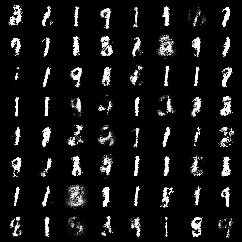



Train Epoch: 12 [0/60000 (0%)]	Generator Loss: 4.277304	Discriminator Loss: 0.117225
Train Epoch: 12 [12800/60000 (21%)]	Generator Loss: 5.010618	Discriminator Loss: 0.110787
Train Epoch: 12 [25600/60000 (43%)]	Generator Loss: 4.019084	Discriminator Loss: 0.123210
Train Epoch: 12 [38400/60000 (64%)]	Generator Loss: 6.274540	Discriminator Loss: 0.096275
Train Epoch: 12 [51200/60000 (85%)]	Generator Loss: 4.752627	Discriminator Loss: 0.119474
====> Epoch: 12 Average generator loss: 4.9350	Average discriminator loss: 0.1015
====> Test set generator loss: 3.3568	Test set discriminator loss: 0.1626
Sample of generated images


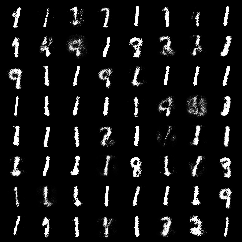



Train Epoch: 13 [0/60000 (0%)]	Generator Loss: 3.967642	Discriminator Loss: 0.145530
Train Epoch: 13 [12800/60000 (21%)]	Generator Loss: 4.968769	Discriminator Loss: 0.135708
Train Epoch: 13 [25600/60000 (43%)]	Generator Loss: 4.412367	Discriminator Loss: 0.167228
Train Epoch: 13 [38400/60000 (64%)]	Generator Loss: 4.000656	Discriminator Loss: 0.123224
Train Epoch: 13 [51200/60000 (85%)]	Generator Loss: 4.678528	Discriminator Loss: 0.121914
====> Epoch: 13 Average generator loss: 4.4632	Average discriminator loss: 0.1193
====> Test set generator loss: 4.4368	Test set discriminator loss: 0.0978
Sample of generated images


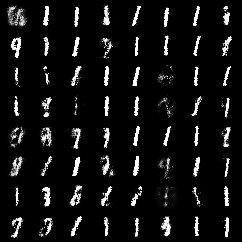



Train Epoch: 14 [0/60000 (0%)]	Generator Loss: 4.213906	Discriminator Loss: 0.113177
Train Epoch: 14 [12800/60000 (21%)]	Generator Loss: 4.790222	Discriminator Loss: 0.106015
Train Epoch: 14 [25600/60000 (43%)]	Generator Loss: 4.589359	Discriminator Loss: 0.122996
Train Epoch: 14 [38400/60000 (64%)]	Generator Loss: 4.200106	Discriminator Loss: 0.156710
Train Epoch: 14 [51200/60000 (85%)]	Generator Loss: 3.906966	Discriminator Loss: 0.186832
====> Epoch: 14 Average generator loss: 4.2719	Average discriminator loss: 0.1263
====> Test set generator loss: 3.7032	Test set discriminator loss: 0.1545
Sample of generated images


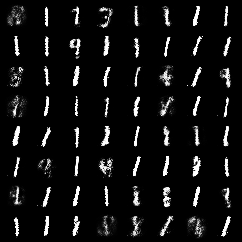



Train Epoch: 15 [0/60000 (0%)]	Generator Loss: 3.961183	Discriminator Loss: 0.132840
Train Epoch: 15 [12800/60000 (21%)]	Generator Loss: 3.541772	Discriminator Loss: 0.110510
Train Epoch: 15 [25600/60000 (43%)]	Generator Loss: 3.542719	Discriminator Loss: 0.155965
Train Epoch: 15 [38400/60000 (64%)]	Generator Loss: 3.957127	Discriminator Loss: 0.176614
Train Epoch: 15 [51200/60000 (85%)]	Generator Loss: 3.558980	Discriminator Loss: 0.184086
====> Epoch: 15 Average generator loss: 4.1140	Average discriminator loss: 0.1398
====> Test set generator loss: 3.2377	Test set discriminator loss: 0.1539
Sample of generated images


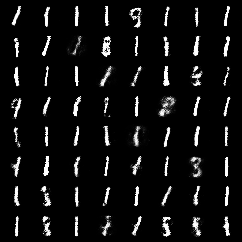



Train Epoch: 16 [0/60000 (0%)]	Generator Loss: 3.721613	Discriminator Loss: 0.098875
Train Epoch: 16 [12800/60000 (21%)]	Generator Loss: 3.223564	Discriminator Loss: 0.153756
Train Epoch: 16 [25600/60000 (43%)]	Generator Loss: 3.767661	Discriminator Loss: 0.157598
Train Epoch: 16 [38400/60000 (64%)]	Generator Loss: 3.834713	Discriminator Loss: 0.201069
Train Epoch: 16 [51200/60000 (85%)]	Generator Loss: 3.780628	Discriminator Loss: 0.132649
====> Epoch: 16 Average generator loss: 3.7042	Average discriminator loss: 0.1556
====> Test set generator loss: 3.5554	Test set discriminator loss: 0.1426
Sample of generated images


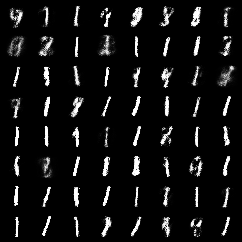



Train Epoch: 17 [0/60000 (0%)]	Generator Loss: 3.821908	Discriminator Loss: 0.097794
Train Epoch: 17 [12800/60000 (21%)]	Generator Loss: 3.760558	Discriminator Loss: 0.180581
Train Epoch: 17 [25600/60000 (43%)]	Generator Loss: 3.458786	Discriminator Loss: 0.197016
Train Epoch: 17 [38400/60000 (64%)]	Generator Loss: 3.735731	Discriminator Loss: 0.313063
Train Epoch: 17 [51200/60000 (85%)]	Generator Loss: 3.256073	Discriminator Loss: 0.197206
====> Epoch: 17 Average generator loss: 3.6228	Average discriminator loss: 0.1695
====> Test set generator loss: 3.0806	Test set discriminator loss: 0.2080
Sample of generated images


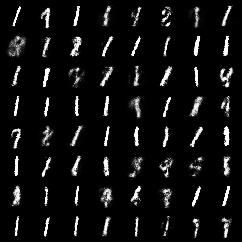



Train Epoch: 18 [0/60000 (0%)]	Generator Loss: 3.968902	Discriminator Loss: 0.245782
Train Epoch: 18 [12800/60000 (21%)]	Generator Loss: 3.168240	Discriminator Loss: 0.165182
Train Epoch: 18 [25600/60000 (43%)]	Generator Loss: 3.566685	Discriminator Loss: 0.170064
Train Epoch: 18 [38400/60000 (64%)]	Generator Loss: 3.292315	Discriminator Loss: 0.171609
Train Epoch: 18 [51200/60000 (85%)]	Generator Loss: 3.976531	Discriminator Loss: 0.097026
====> Epoch: 18 Average generator loss: 3.5607	Average discriminator loss: 0.1814
====> Test set generator loss: 2.6849	Test set discriminator loss: 0.2294
Sample of generated images


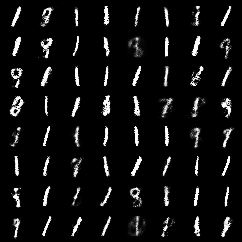



Train Epoch: 19 [0/60000 (0%)]	Generator Loss: 2.724503	Discriminator Loss: 0.203748
Train Epoch: 19 [12800/60000 (21%)]	Generator Loss: 3.395651	Discriminator Loss: 0.106497
Train Epoch: 19 [25600/60000 (43%)]	Generator Loss: 3.580187	Discriminator Loss: 0.145985
Train Epoch: 19 [38400/60000 (64%)]	Generator Loss: 3.100420	Discriminator Loss: 0.183411
Train Epoch: 19 [51200/60000 (85%)]	Generator Loss: 3.584641	Discriminator Loss: 0.205815
====> Epoch: 19 Average generator loss: 3.4013	Average discriminator loss: 0.1834
====> Test set generator loss: 3.5921	Test set discriminator loss: 0.1765
Sample of generated images


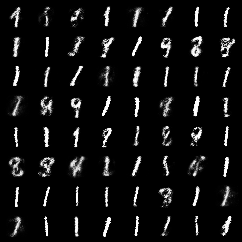



Train Epoch: 20 [0/60000 (0%)]	Generator Loss: 3.820683	Discriminator Loss: 0.177716
Train Epoch: 20 [12800/60000 (21%)]	Generator Loss: 3.630148	Discriminator Loss: 0.209337
Train Epoch: 20 [25600/60000 (43%)]	Generator Loss: 3.653651	Discriminator Loss: 0.205410
Train Epoch: 20 [38400/60000 (64%)]	Generator Loss: 3.962535	Discriminator Loss: 0.175254
Train Epoch: 20 [51200/60000 (85%)]	Generator Loss: 3.769578	Discriminator Loss: 0.139147
====> Epoch: 20 Average generator loss: 3.4600	Average discriminator loss: 0.1863
====> Test set generator loss: 3.4247	Test set discriminator loss: 0.1866
Sample of generated images


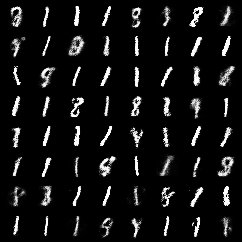



Train Epoch: 21 [0/60000 (0%)]	Generator Loss: 3.634173	Discriminator Loss: 0.128166
Train Epoch: 21 [12800/60000 (21%)]	Generator Loss: 3.239796	Discriminator Loss: 0.241919
Train Epoch: 21 [25600/60000 (43%)]	Generator Loss: 3.668280	Discriminator Loss: 0.181725
Train Epoch: 21 [38400/60000 (64%)]	Generator Loss: 3.600366	Discriminator Loss: 0.139460
Train Epoch: 21 [51200/60000 (85%)]	Generator Loss: 2.879642	Discriminator Loss: 0.185708
====> Epoch: 21 Average generator loss: 3.3873	Average discriminator loss: 0.1929
====> Test set generator loss: 2.8021	Test set discriminator loss: 0.2111
Sample of generated images


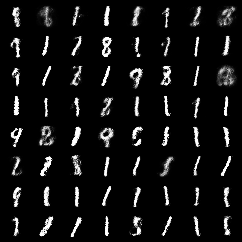



Train Epoch: 22 [0/60000 (0%)]	Generator Loss: 3.018089	Discriminator Loss: 0.214732
Train Epoch: 22 [12800/60000 (21%)]	Generator Loss: 3.625869	Discriminator Loss: 0.144824
Train Epoch: 22 [25600/60000 (43%)]	Generator Loss: 3.020776	Discriminator Loss: 0.189152
Train Epoch: 22 [38400/60000 (64%)]	Generator Loss: 3.287476	Discriminator Loss: 0.175841
Train Epoch: 22 [51200/60000 (85%)]	Generator Loss: 3.798411	Discriminator Loss: 0.179240
====> Epoch: 22 Average generator loss: 3.2380	Average discriminator loss: 0.1921
====> Test set generator loss: 2.5471	Test set discriminator loss: 0.2000
Sample of generated images


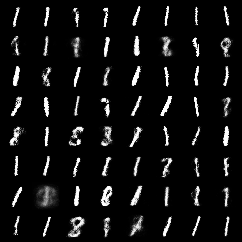



Train Epoch: 23 [0/60000 (0%)]	Generator Loss: 2.567064	Discriminator Loss: 0.222607
Train Epoch: 23 [12800/60000 (21%)]	Generator Loss: 3.190685	Discriminator Loss: 0.188008
Train Epoch: 23 [25600/60000 (43%)]	Generator Loss: 2.656649	Discriminator Loss: 0.199821
Train Epoch: 23 [38400/60000 (64%)]	Generator Loss: 3.262152	Discriminator Loss: 0.231437
Train Epoch: 23 [51200/60000 (85%)]	Generator Loss: 3.079261	Discriminator Loss: 0.162207
====> Epoch: 23 Average generator loss: 3.2185	Average discriminator loss: 0.1893
====> Test set generator loss: 3.0779	Test set discriminator loss: 0.1763
Sample of generated images


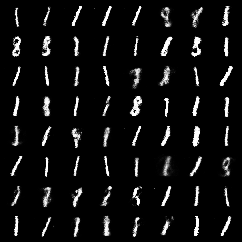



Train Epoch: 24 [0/60000 (0%)]	Generator Loss: 3.230656	Discriminator Loss: 0.178573
Train Epoch: 24 [12800/60000 (21%)]	Generator Loss: 3.122016	Discriminator Loss: 0.183835
Train Epoch: 24 [25600/60000 (43%)]	Generator Loss: 3.306786	Discriminator Loss: 0.201009
Train Epoch: 24 [38400/60000 (64%)]	Generator Loss: 3.086363	Discriminator Loss: 0.204268
Train Epoch: 24 [51200/60000 (85%)]	Generator Loss: 2.861671	Discriminator Loss: 0.213552
====> Epoch: 24 Average generator loss: 3.1582	Average discriminator loss: 0.1874
====> Test set generator loss: 2.9552	Test set discriminator loss: 0.1967
Sample of generated images


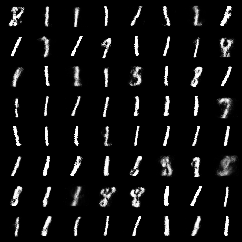



Train Epoch: 25 [0/60000 (0%)]	Generator Loss: 3.127554	Discriminator Loss: 0.182604
Train Epoch: 25 [12800/60000 (21%)]	Generator Loss: 3.206546	Discriminator Loss: 0.218629
Train Epoch: 25 [25600/60000 (43%)]	Generator Loss: 2.937896	Discriminator Loss: 0.174842
Train Epoch: 25 [38400/60000 (64%)]	Generator Loss: 3.030755	Discriminator Loss: 0.170419
Train Epoch: 25 [51200/60000 (85%)]	Generator Loss: 3.080400	Discriminator Loss: 0.237225
====> Epoch: 25 Average generator loss: 3.1271	Average discriminator loss: 0.1902
====> Test set generator loss: 3.0650	Test set discriminator loss: 0.2009
Sample of generated images


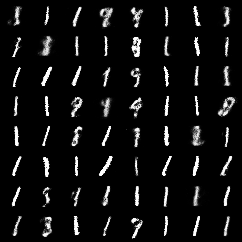



Train Epoch: 26 [0/60000 (0%)]	Generator Loss: 3.170090	Discriminator Loss: 0.275966
Train Epoch: 26 [12800/60000 (21%)]	Generator Loss: 3.139439	Discriminator Loss: 0.136998
Train Epoch: 26 [25600/60000 (43%)]	Generator Loss: 3.153416	Discriminator Loss: 0.190517
Train Epoch: 26 [38400/60000 (64%)]	Generator Loss: 2.927285	Discriminator Loss: 0.171000
Train Epoch: 26 [51200/60000 (85%)]	Generator Loss: 3.082957	Discriminator Loss: 0.213445
====> Epoch: 26 Average generator loss: 3.0959	Average discriminator loss: 0.1921
====> Test set generator loss: 3.1872	Test set discriminator loss: 0.2396
Sample of generated images


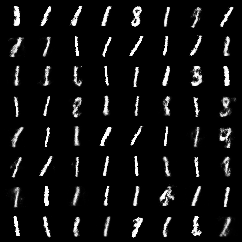



Train Epoch: 27 [0/60000 (0%)]	Generator Loss: 3.336578	Discriminator Loss: 0.201503
Train Epoch: 27 [12800/60000 (21%)]	Generator Loss: 3.277816	Discriminator Loss: 0.201263
Train Epoch: 27 [25600/60000 (43%)]	Generator Loss: 2.929577	Discriminator Loss: 0.243441
Train Epoch: 27 [38400/60000 (64%)]	Generator Loss: 3.456913	Discriminator Loss: 0.137149
Train Epoch: 27 [51200/60000 (85%)]	Generator Loss: 2.784205	Discriminator Loss: 0.173042
====> Epoch: 27 Average generator loss: 3.1382	Average discriminator loss: 0.1889
====> Test set generator loss: 3.3636	Test set discriminator loss: 0.1948
Sample of generated images


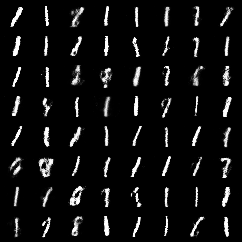



Train Epoch: 28 [0/60000 (0%)]	Generator Loss: 3.528647	Discriminator Loss: 0.143053
Train Epoch: 28 [12800/60000 (21%)]	Generator Loss: 3.559201	Discriminator Loss: 0.158827
Train Epoch: 28 [25600/60000 (43%)]	Generator Loss: 3.024304	Discriminator Loss: 0.227463
Train Epoch: 28 [38400/60000 (64%)]	Generator Loss: 2.747488	Discriminator Loss: 0.136999
Train Epoch: 28 [51200/60000 (85%)]	Generator Loss: 3.179731	Discriminator Loss: 0.192741
====> Epoch: 28 Average generator loss: 3.0825	Average discriminator loss: 0.1908
====> Test set generator loss: 2.6956	Test set discriminator loss: 0.1748
Sample of generated images


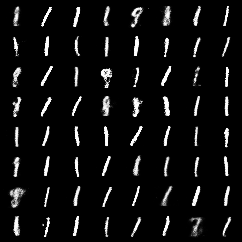



Train Epoch: 29 [0/60000 (0%)]	Generator Loss: 3.097014	Discriminator Loss: 0.156828
Train Epoch: 29 [12800/60000 (21%)]	Generator Loss: 2.900186	Discriminator Loss: 0.177596
Train Epoch: 29 [25600/60000 (43%)]	Generator Loss: 3.702179	Discriminator Loss: 0.132870
Train Epoch: 29 [38400/60000 (64%)]	Generator Loss: 3.178306	Discriminator Loss: 0.160924
Train Epoch: 29 [51200/60000 (85%)]	Generator Loss: 2.458582	Discriminator Loss: 0.225677
====> Epoch: 29 Average generator loss: 3.0560	Average discriminator loss: 0.1898
====> Test set generator loss: 2.8540	Test set discriminator loss: 0.1937
Sample of generated images


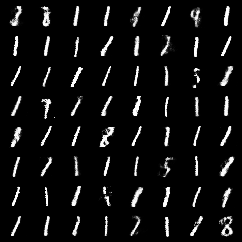



Train Epoch: 30 [0/60000 (0%)]	Generator Loss: 3.051954	Discriminator Loss: 0.179755
Train Epoch: 30 [12800/60000 (21%)]	Generator Loss: 2.839641	Discriminator Loss: 0.204073
Train Epoch: 30 [25600/60000 (43%)]	Generator Loss: 2.758458	Discriminator Loss: 0.197970
Train Epoch: 30 [38400/60000 (64%)]	Generator Loss: 3.122703	Discriminator Loss: 0.164551
Train Epoch: 30 [51200/60000 (85%)]	Generator Loss: 3.172157	Discriminator Loss: 0.197170
====> Epoch: 30 Average generator loss: 2.9627	Average discriminator loss: 0.1930
====> Test set generator loss: 3.3641	Test set discriminator loss: 0.2345
Sample of generated images


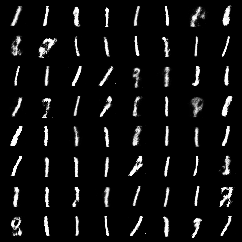



Train Epoch: 31 [0/60000 (0%)]	Generator Loss: 3.519009	Discriminator Loss: 0.203914
Train Epoch: 31 [12800/60000 (21%)]	Generator Loss: 3.233082	Discriminator Loss: 0.169988
Train Epoch: 31 [25600/60000 (43%)]	Generator Loss: 2.505966	Discriminator Loss: 0.241785
Train Epoch: 31 [38400/60000 (64%)]	Generator Loss: 3.004566	Discriminator Loss: 0.216657
Train Epoch: 31 [51200/60000 (85%)]	Generator Loss: 3.083627	Discriminator Loss: 0.155169
====> Epoch: 31 Average generator loss: 2.9036	Average discriminator loss: 0.1921
====> Test set generator loss: 2.8932	Test set discriminator loss: 0.2248
Sample of generated images


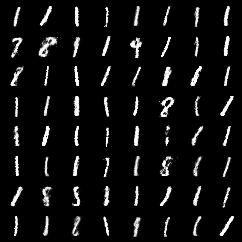



Train Epoch: 32 [0/60000 (0%)]	Generator Loss: 2.964153	Discriminator Loss: 0.215372
Train Epoch: 32 [12800/60000 (21%)]	Generator Loss: 3.671156	Discriminator Loss: 0.136160
Train Epoch: 32 [25600/60000 (43%)]	Generator Loss: 3.115947	Discriminator Loss: 0.186220
Train Epoch: 32 [38400/60000 (64%)]	Generator Loss: 2.930588	Discriminator Loss: 0.168974
Train Epoch: 32 [51200/60000 (85%)]	Generator Loss: 2.957853	Discriminator Loss: 0.154567
====> Epoch: 32 Average generator loss: 2.9660	Average discriminator loss: 0.1881
====> Test set generator loss: 2.9439	Test set discriminator loss: 0.2015
Sample of generated images


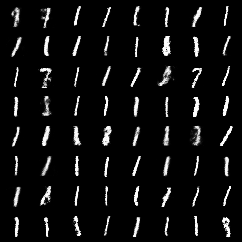



Train Epoch: 33 [0/60000 (0%)]	Generator Loss: 3.219165	Discriminator Loss: 0.197231
Train Epoch: 33 [12800/60000 (21%)]	Generator Loss: 2.749154	Discriminator Loss: 0.182676
Train Epoch: 33 [25600/60000 (43%)]	Generator Loss: 2.791667	Discriminator Loss: 0.180674
Train Epoch: 33 [38400/60000 (64%)]	Generator Loss: 2.639218	Discriminator Loss: 0.268975
Train Epoch: 33 [51200/60000 (85%)]	Generator Loss: 2.686566	Discriminator Loss: 0.207566
====> Epoch: 33 Average generator loss: 2.9742	Average discriminator loss: 0.1901
====> Test set generator loss: 2.3592	Test set discriminator loss: 0.2086
Sample of generated images


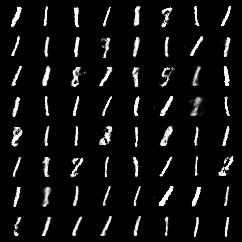



Train Epoch: 34 [0/60000 (0%)]	Generator Loss: 2.315651	Discriminator Loss: 0.196720
Train Epoch: 34 [12800/60000 (21%)]	Generator Loss: 3.123592	Discriminator Loss: 0.190056
Train Epoch: 34 [25600/60000 (43%)]	Generator Loss: 3.175798	Discriminator Loss: 0.180204
Train Epoch: 34 [38400/60000 (64%)]	Generator Loss: 3.116118	Discriminator Loss: 0.113021
Train Epoch: 34 [51200/60000 (85%)]	Generator Loss: 3.210087	Discriminator Loss: 0.113339
====> Epoch: 34 Average generator loss: 2.9714	Average discriminator loss: 0.1866
====> Test set generator loss: 3.0843	Test set discriminator loss: 0.1910
Sample of generated images


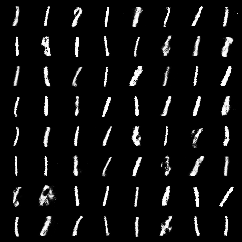



Train Epoch: 35 [0/60000 (0%)]	Generator Loss: 3.097270	Discriminator Loss: 0.164097
Train Epoch: 35 [12800/60000 (21%)]	Generator Loss: 2.799707	Discriminator Loss: 0.218550
Train Epoch: 35 [25600/60000 (43%)]	Generator Loss: 3.318277	Discriminator Loss: 0.221928
Train Epoch: 35 [38400/60000 (64%)]	Generator Loss: 3.108254	Discriminator Loss: 0.201260
Train Epoch: 35 [51200/60000 (85%)]	Generator Loss: 2.740137	Discriminator Loss: 0.172943
====> Epoch: 35 Average generator loss: 3.0083	Average discriminator loss: 0.1858
====> Test set generator loss: 2.3887	Test set discriminator loss: 0.2204
Sample of generated images


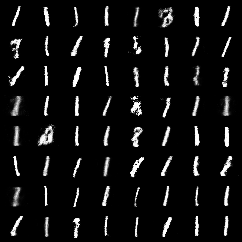



Train Epoch: 36 [0/60000 (0%)]	Generator Loss: 2.388208	Discriminator Loss: 0.297499
Train Epoch: 36 [12800/60000 (21%)]	Generator Loss: 3.041200	Discriminator Loss: 0.155655
Train Epoch: 36 [25600/60000 (43%)]	Generator Loss: 3.175065	Discriminator Loss: 0.260416
Train Epoch: 36 [38400/60000 (64%)]	Generator Loss: 2.918469	Discriminator Loss: 0.228896
Train Epoch: 36 [51200/60000 (85%)]	Generator Loss: 3.109752	Discriminator Loss: 0.164885
====> Epoch: 36 Average generator loss: 2.9576	Average discriminator loss: 0.1868
====> Test set generator loss: 2.8180	Test set discriminator loss: 0.2017
Sample of generated images


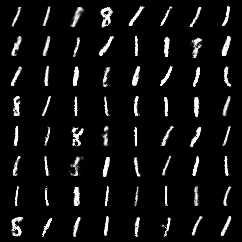



Train Epoch: 37 [0/60000 (0%)]	Generator Loss: 2.987918	Discriminator Loss: 0.224093
Train Epoch: 37 [12800/60000 (21%)]	Generator Loss: 2.932947	Discriminator Loss: 0.232881
Train Epoch: 37 [25600/60000 (43%)]	Generator Loss: 3.296065	Discriminator Loss: 0.177926
Train Epoch: 37 [38400/60000 (64%)]	Generator Loss: 2.762724	Discriminator Loss: 0.164517
Train Epoch: 37 [51200/60000 (85%)]	Generator Loss: 2.711362	Discriminator Loss: 0.194325
====> Epoch: 37 Average generator loss: 2.9018	Average discriminator loss: 0.1886
====> Test set generator loss: 2.4796	Test set discriminator loss: 0.1926
Sample of generated images


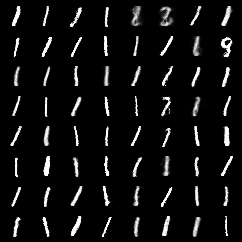



Train Epoch: 38 [0/60000 (0%)]	Generator Loss: 2.638491	Discriminator Loss: 0.156444
Train Epoch: 38 [12800/60000 (21%)]	Generator Loss: 3.035897	Discriminator Loss: 0.230397
Train Epoch: 38 [25600/60000 (43%)]	Generator Loss: 2.404984	Discriminator Loss: 0.226075
Train Epoch: 38 [38400/60000 (64%)]	Generator Loss: 2.989495	Discriminator Loss: 0.156872
Train Epoch: 38 [51200/60000 (85%)]	Generator Loss: 2.772445	Discriminator Loss: 0.260714
====> Epoch: 38 Average generator loss: 2.8959	Average discriminator loss: 0.1894
====> Test set generator loss: 3.2020	Test set discriminator loss: 0.2093
Sample of generated images


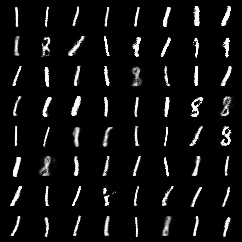



Train Epoch: 39 [0/60000 (0%)]	Generator Loss: 3.158532	Discriminator Loss: 0.211386
Train Epoch: 39 [12800/60000 (21%)]	Generator Loss: 3.110557	Discriminator Loss: 0.155491
Train Epoch: 39 [25600/60000 (43%)]	Generator Loss: 2.546872	Discriminator Loss: 0.230076
Train Epoch: 39 [38400/60000 (64%)]	Generator Loss: 3.242343	Discriminator Loss: 0.176741
Train Epoch: 39 [51200/60000 (85%)]	Generator Loss: 2.993173	Discriminator Loss: 0.164936
====> Epoch: 39 Average generator loss: 2.8270	Average discriminator loss: 0.1887
====> Test set generator loss: 2.7830	Test set discriminator loss: 0.1982
Sample of generated images


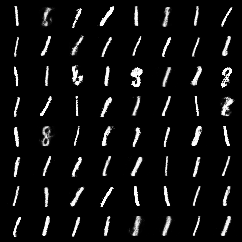



Train Epoch: 40 [0/60000 (0%)]	Generator Loss: 2.888545	Discriminator Loss: 0.145124
Train Epoch: 40 [12800/60000 (21%)]	Generator Loss: 2.548762	Discriminator Loss: 0.208729
Train Epoch: 40 [25600/60000 (43%)]	Generator Loss: 3.029694	Discriminator Loss: 0.186759
Train Epoch: 40 [38400/60000 (64%)]	Generator Loss: 2.963629	Discriminator Loss: 0.157060
Train Epoch: 40 [51200/60000 (85%)]	Generator Loss: 3.072876	Discriminator Loss: 0.228360
====> Epoch: 40 Average generator loss: 2.8546	Average discriminator loss: 0.1874
====> Test set generator loss: 3.0441	Test set discriminator loss: 0.2106
Sample of generated images


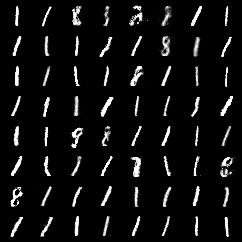



Train Epoch: 41 [0/60000 (0%)]	Generator Loss: 3.298046	Discriminator Loss: 0.202410
Train Epoch: 41 [12800/60000 (21%)]	Generator Loss: 2.903893	Discriminator Loss: 0.138634
Train Epoch: 41 [25600/60000 (43%)]	Generator Loss: 2.821230	Discriminator Loss: 0.194834
Train Epoch: 41 [38400/60000 (64%)]	Generator Loss: 2.725509	Discriminator Loss: 0.169232
Train Epoch: 41 [51200/60000 (85%)]	Generator Loss: 2.464497	Discriminator Loss: 0.213362
====> Epoch: 41 Average generator loss: 2.8405	Average discriminator loss: 0.1876
====> Test set generator loss: 2.9331	Test set discriminator loss: 0.1844
Sample of generated images


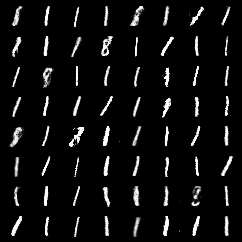



Train Epoch: 42 [0/60000 (0%)]	Generator Loss: 2.808756	Discriminator Loss: 0.158520
Train Epoch: 42 [12800/60000 (21%)]	Generator Loss: 2.506866	Discriminator Loss: 0.174266
Train Epoch: 42 [25600/60000 (43%)]	Generator Loss: 2.613789	Discriminator Loss: 0.170219
Train Epoch: 42 [38400/60000 (64%)]	Generator Loss: 2.805717	Discriminator Loss: 0.161167
Train Epoch: 42 [51200/60000 (85%)]	Generator Loss: 2.714525	Discriminator Loss: 0.246414
====> Epoch: 42 Average generator loss: 2.8398	Average discriminator loss: 0.1882
====> Test set generator loss: 2.8624	Test set discriminator loss: 0.1996
Sample of generated images


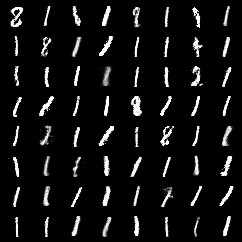



Train Epoch: 43 [0/60000 (0%)]	Generator Loss: 2.942109	Discriminator Loss: 0.205450
Train Epoch: 43 [12800/60000 (21%)]	Generator Loss: 3.241106	Discriminator Loss: 0.244300
Train Epoch: 43 [25600/60000 (43%)]	Generator Loss: 2.953117	Discriminator Loss: 0.213025
Train Epoch: 43 [38400/60000 (64%)]	Generator Loss: 2.913654	Discriminator Loss: 0.220385
Train Epoch: 43 [51200/60000 (85%)]	Generator Loss: 3.012913	Discriminator Loss: 0.210104
====> Epoch: 43 Average generator loss: 2.8279	Average discriminator loss: 0.1871
====> Test set generator loss: 2.9296	Test set discriminator loss: 0.2017
Sample of generated images


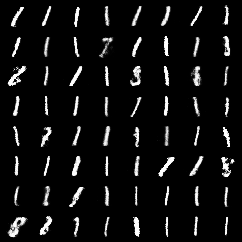



Train Epoch: 44 [0/60000 (0%)]	Generator Loss: 3.102144	Discriminator Loss: 0.130807
Train Epoch: 44 [12800/60000 (21%)]	Generator Loss: 2.227477	Discriminator Loss: 0.204864
Train Epoch: 44 [25600/60000 (43%)]	Generator Loss: 2.862734	Discriminator Loss: 0.134928
Train Epoch: 44 [38400/60000 (64%)]	Generator Loss: 2.923532	Discriminator Loss: 0.200772
Train Epoch: 44 [51200/60000 (85%)]	Generator Loss: 3.133517	Discriminator Loss: 0.168483
====> Epoch: 44 Average generator loss: 2.8449	Average discriminator loss: 0.1880
====> Test set generator loss: 2.9655	Test set discriminator loss: 0.1854
Sample of generated images


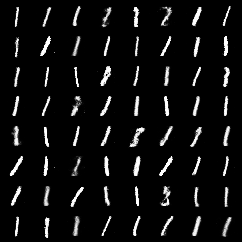



Train Epoch: 45 [0/60000 (0%)]	Generator Loss: 2.592725	Discriminator Loss: 0.255794
Train Epoch: 45 [12800/60000 (21%)]	Generator Loss: 2.767161	Discriminator Loss: 0.224969
Train Epoch: 45 [25600/60000 (43%)]	Generator Loss: 2.809927	Discriminator Loss: 0.180405
Train Epoch: 45 [38400/60000 (64%)]	Generator Loss: 2.619548	Discriminator Loss: 0.124560
Train Epoch: 45 [51200/60000 (85%)]	Generator Loss: 2.564286	Discriminator Loss: 0.198705
====> Epoch: 45 Average generator loss: 2.7845	Average discriminator loss: 0.1874
====> Test set generator loss: 2.6972	Test set discriminator loss: 0.2046
Sample of generated images


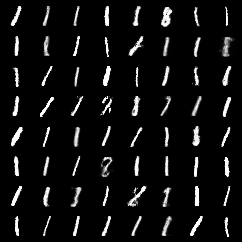



Train Epoch: 46 [0/60000 (0%)]	Generator Loss: 2.921578	Discriminator Loss: 0.166815
Train Epoch: 46 [12800/60000 (21%)]	Generator Loss: 2.802001	Discriminator Loss: 0.189438
Train Epoch: 46 [25600/60000 (43%)]	Generator Loss: 2.862527	Discriminator Loss: 0.154650
Train Epoch: 46 [38400/60000 (64%)]	Generator Loss: 2.413424	Discriminator Loss: 0.225881
Train Epoch: 46 [51200/60000 (85%)]	Generator Loss: 2.481202	Discriminator Loss: 0.189866
====> Epoch: 46 Average generator loss: 2.7343	Average discriminator loss: 0.1907
====> Test set generator loss: 2.6412	Test set discriminator loss: 0.1865
Sample of generated images


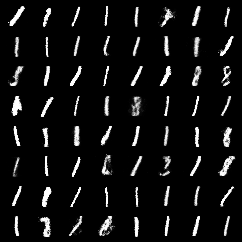



Train Epoch: 47 [0/60000 (0%)]	Generator Loss: 2.825600	Discriminator Loss: 0.159214
Train Epoch: 47 [12800/60000 (21%)]	Generator Loss: 2.423963	Discriminator Loss: 0.182723
Train Epoch: 47 [25600/60000 (43%)]	Generator Loss: 2.545159	Discriminator Loss: 0.194119
Train Epoch: 47 [38400/60000 (64%)]	Generator Loss: 2.755250	Discriminator Loss: 0.136695
Train Epoch: 47 [51200/60000 (85%)]	Generator Loss: 3.100785	Discriminator Loss: 0.131877
====> Epoch: 47 Average generator loss: 2.7277	Average discriminator loss: 0.1883
====> Test set generator loss: 2.4382	Test set discriminator loss: 0.1957
Sample of generated images


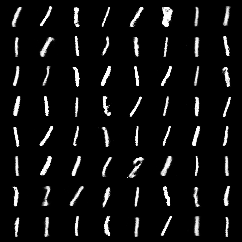



Train Epoch: 48 [0/60000 (0%)]	Generator Loss: 2.711389	Discriminator Loss: 0.154391
Train Epoch: 48 [12800/60000 (21%)]	Generator Loss: 2.748271	Discriminator Loss: 0.163643
Train Epoch: 48 [25600/60000 (43%)]	Generator Loss: 2.703853	Discriminator Loss: 0.189213
Train Epoch: 48 [38400/60000 (64%)]	Generator Loss: 2.690757	Discriminator Loss: 0.156779
Train Epoch: 48 [51200/60000 (85%)]	Generator Loss: 2.578388	Discriminator Loss: 0.226824
====> Epoch: 48 Average generator loss: 2.7551	Average discriminator loss: 0.1892
====> Test set generator loss: 2.7683	Test set discriminator loss: 0.1973
Sample of generated images


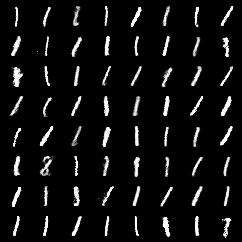



Train Epoch: 49 [0/60000 (0%)]	Generator Loss: 2.857462	Discriminator Loss: 0.151606
Train Epoch: 49 [12800/60000 (21%)]	Generator Loss: 2.834907	Discriminator Loss: 0.138218
Train Epoch: 49 [25600/60000 (43%)]	Generator Loss: 2.810812	Discriminator Loss: 0.150618
Train Epoch: 49 [38400/60000 (64%)]	Generator Loss: 2.220030	Discriminator Loss: 0.163830
Train Epoch: 49 [51200/60000 (85%)]	Generator Loss: 2.761139	Discriminator Loss: 0.193904
====> Epoch: 49 Average generator loss: 2.7518	Average discriminator loss: 0.1878
====> Test set generator loss: 2.7816	Test set discriminator loss: 0.1965
Sample of generated images


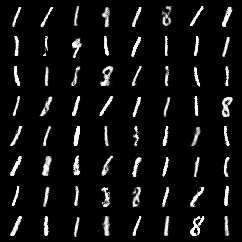



Train Epoch: 50 [0/60000 (0%)]	Generator Loss: 2.780803	Discriminator Loss: 0.196303
Train Epoch: 50 [12800/60000 (21%)]	Generator Loss: 3.195406	Discriminator Loss: 0.160435
Train Epoch: 50 [25600/60000 (43%)]	Generator Loss: 3.031807	Discriminator Loss: 0.168564
Train Epoch: 50 [38400/60000 (64%)]	Generator Loss: 2.692734	Discriminator Loss: 0.256843
Train Epoch: 50 [51200/60000 (85%)]	Generator Loss: 2.926836	Discriminator Loss: 0.163957
====> Epoch: 50 Average generator loss: 2.7684	Average discriminator loss: 0.1879
====> Test set generator loss: 2.7489	Test set discriminator loss: 0.1961
Sample of generated images


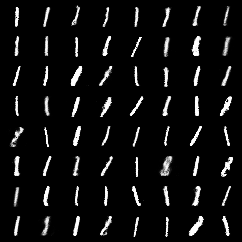

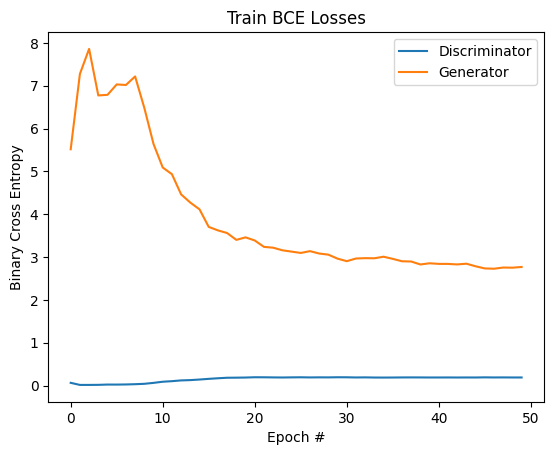

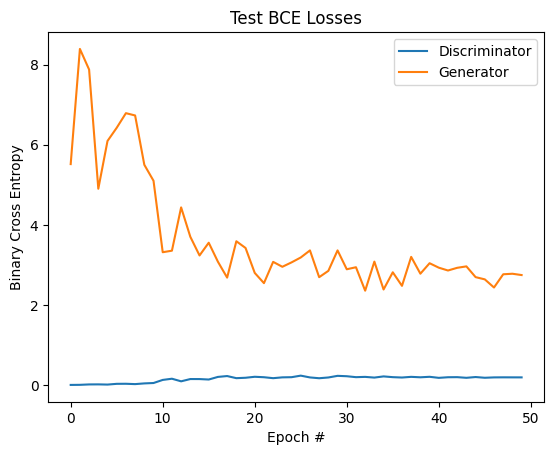

In [6]:
# train and test gan
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = optim.Adam(generator_model.parameters(), lr=1e-3)
discriminator_model = Discriminator().to(device)
discriminator_optimizer = optim.Adam(discriminator_model.parameters(), lr=1e-3)
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'results/sample_' + str(epoch) + '.png')
        print('Sample of generated images')
        display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()


# Explanation

Comparing both VAE and GAN, the quality of the sampled images generated by GAN is much higher than the ones generated by VAE. In particular, the ones generated by GAN are much clearer and closer to real handwriting while the digits in the generated VAE images are more blurry. Note that the VAE-sampled images contain a good variety of digits from 0-9, while the GAN-sampled images contain only 1s.

Mode collapse is a likely explanation for the better quality but smaller variety of digits in the sampled images generated by GAN (compared to VAE). Mode collapse occurs when the generator only generates a small set of outputs that can easily fool the discriminator and thus learns to keep generating the same type better and better. In our case, as the digit 1 is the easiest to generate compared to other digits (i.e. no curves and cusps), the generator will keep generating high quality 1s in its sampled images to fool the discriminator, which also explain the image quality difference between GAN and VAE.